In [82]:

!pip install pandas datasets scikit-learn matplotlib
!pip install langchain_openai openai  # Assuming this package exists and provides AzureOpenAIEmbeddings

In [47]:
import pandas as pd
from datasets import load_dataset
# Load the dataset
dataset = load_dataset("Vinom/ClimateChangeQA", split='train[:100]')  # Limit to 2000 rows

# Convert to DataFrame
df = pd.DataFrame(dataset)

# Inspect the dataset
print(df.columns)
print(df.head())

Index(['answer', 'question'], dtype='object')
                                              answer  \
0  Ocean acidification, caused by the absorption ...   
1  Deforestation contributes to climate change by...   
2  Climate change can disrupt the habitats and fo...   
3  Climate change can contribute to the increase ...   
4  Melting polar ice caps can result in the rise ...   

                                            question  
0  What are the potential consequences of ocean a...  
1  What role does deforestation play in exacerbat...  
2  How can climate change impact the migration pa...  
3  How does climate change affect the frequency a...  
4  How can melting polar ice caps impact global s...  


In [48]:
import os
import numpy as np
from langchain_openai import AzureOpenAIEmbeddings
from sklearn.preprocessing import normalize
from tqdm import tqdm

# Azure OpenAI Configuration
os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["OPENAI_API_VERSION"] = "2023-05-15"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://insideout.openai.azure.com/"
os.environ["OPENAI_API_KEY"] = "" #removed for privacy
os.environ["OPENAI_EMBEDDINGS_DEPLOYMENT"] = "text-embedding-3-small"

# Initialize the embeddings model
embeddings = AzureOpenAIEmbeddings(deployment=os.environ["OPENAI_EMBEDDINGS_DEPLOYMENT"])

# Embed the dataset
def embed_texts_in_batches(texts, batch_size=2):
    embeddings_list = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = [embeddings.embed_query(text) for text in batch_texts]
        embeddings_list.extend(batch_embeddings)
    return np.array(embeddings_list)

# Assume df is already loaded as a DataFrame with a 'question' column
questions = df['question'].tolist()
embedded_data = embed_texts_in_batches(questions, batch_size=2)

# Normalize the embeddings
embedded_data = normalize(embedded_data)

# Save the embeddings
np.save('embedded_data.npy', embedded_data)

100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


/tmp/ipykernel_38084/1196106772.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5, cmap='viridis')


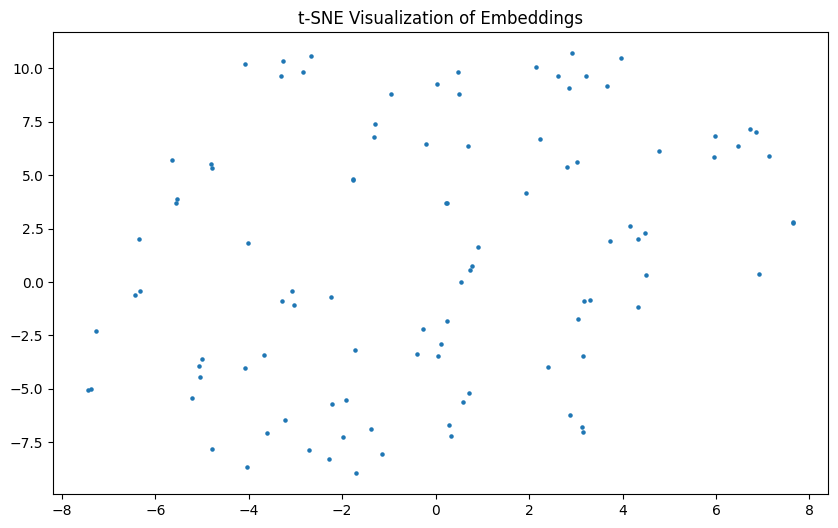

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load the embeddings
embedded_data = np.load('embedded_data.npy')

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embedded_data)

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5, cmap='viridis')
plt.title('t-SNE Visualization of Embeddings')
plt.show()

In [50]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to perform a search
def search(query, embedded_data, top_k=1):
    query_vector = embeddings.embed_query(query)
    query_vector = np.array(query_vector).reshape(1, -1)
    similarities = cosine_similarity(query_vector, embedded_data)
    top_indices = similarities[0].argsort()[-top_k:][::-1]
    return df.iloc[top_indices]

# Example search
query = "How does climate change affect polar bears? "
results = search(query, embedded_data)

print(results)

                                               answer  \
51  Climate change can alter the migration pattern...   

                                             question  
51  How does climate change affect the migration p...  


In [51]:
from pymilvus import MilvusClient
milvus_client = MilvusClient(uri="./milvus_demo.db")
collection_name = "my_rag_collection"
embedding_dim = embedded_data.shape[1]

# Check if the collection already exists and drop it if it does
if milvus_client.has_collection(collection_name):
    milvus_client.drop_collection(collection_name)

# Create a new collection
milvus_client.create_collection(
    collection_name=collection_name,
    dimension=embedding_dim,
    metric_type="IP",  # Inner product distance
    consistency_level="Strong",  # Strong consistency level
)


In [52]:
# Prepare data for insertion
data = []

for i, question in enumerate(tqdm(questions, desc="Creating embeddings")):
    data.append({"id": i, "vector": embedded_data[i].tolist(), "text": question})

# Insert data into Milvus
milvus_client.insert(collection_name=collection_name, data=data)
print("Data inserted into Milvus.")

Creating embeddings: 100%|██████████| 100/100 [00:00<00:00, 54827.50it/s]

Data inserted into Milvus.


In [79]:
def search(query, collection_name, top_k=3):
    query_vector = embeddings.embed_query(query)
    search_res = milvus_client.search(
        collection_name=collection_name,
        data=[query_vector],
        limit=top_k,
        search_params={"metric_type": "IP", "params": {}},
        output_fields=["text"],
    )
    return search_res

question = "WHat is climate change?"
search_res = search(question, collection_name) #

In [54]:
import json
retrieved_lines_with_distances = [
    (res["entity"]["text"], res["distance"]) for res in search_res[0]
]
print(json.dumps(retrieved_lines_with_distances, indent=4))

[
    [
        "How can innovative technologies like blockchain and IoT contribute to climate change mitigation efforts, and what challenges may arise in their implementation?",
        0.1731952726840973
    ],
    [
        "How can innovative technology solutions contribute to climate change adaptation and mitigation, and what ethical considerations should be taken into account in their development and deployment?",
        0.16516974568367004
    ],
    [
        "How can incorporating biomimicry principles into technology innovation help address climate change challenges, and what implications does it have for sustainable development?",
        0.15519648790359497
    ]
]


In [81]:
import os
import numpy as np
from pymilvus import MilvusClient
import openai
import json

# Assuming `retrieved_lines_with_distances` and `question` are already defined

context = "\n".join(
    [line_with_distance[0] for line_with_distance in retrieved_lines_with_distances]
)

SYSTEM_PROMPT = """
You are an AI assistant. Summarize the provided contextual passage snippets accurately and concisely.
"""

USER_PROMPT = f"""
Summarize the following pieces of information enclosed in <context> tags.
<context>
{context}
</context>
"""

# Azure OpenAI Configuration
api_version = "2023-07-01-preview"
azure_endpoint = "https://insideout.openai.azure.com/"  # Replace with your Azure OpenAI endpoint
api_key = ""  # Replace with your Azure OpenAI API key

# Initialize OpenAI client with Azure-specific settings
client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=azure_endpoint,
    api_key=api_key
)

# Generate response using the OpenAI Chat API
response = client.chat.completions.create(
    model="gpt4o",  # Adjust the model name if necessary
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": USER_PROMPT},
    ],
    max_tokens=300
)

# Print the response from the OpenAI API
print(response.choices[0].message.content.strip())

Climate change negatively impacts the biodiversity of ecosystems globally, affecting the migration patterns of wildlife species and marine life. It also influences human migration patterns, disrupts animal migration across different continents, and alters the frequency and intensity of natural disasters. Additionally, climate change can significantly impact the mental health and well-being of individuals and communities worldwide.
